# Approach

1. > compare Embeddings (```minorminer```) and choose the best
1. > compare Chain Settings and choose the best
1. > compare Anneal Times and choose the best
1. > compare Anneal Schedules and choose the best

## QUBO

### Imports

In [2]:
import sys
sys.path.append("..")
from qubo_util import *

import dimod
import numpy as np
import pandas as pd
import networkx as nx
import minorminer
import dwave.inspector
import matplotlib.pyplot as plt
from dwave.system.samplers import DWaveSampler
from dwave.embedding.chain_strength import scaled, uniform_torque_compensation
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite

### Config

In [3]:
from dwave.cloud import Client
client = Client.from_config(config_file='/Users/jonas/Library/Application Support/dwave/dwave.conf')

### Jobs

In [4]:
### Lets define the basics

bend = [0, 1, 2]
weld = [3, 4]
paint =  [5]

bend_length = 2
weld_length = 3
paint_length = 6

t_step = 3
t_step_in_sec = 30

In [5]:
jobs = [(0, 0, 1, 2, 1, 3),
 (1, 0, 0, 2, 0, 1)]

In [6]:
# OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate 

m_t_steps = max_time(jobs, bend_length, weld_length, paint_length)

m_time = m_t_steps * t_step_in_sec
    
print('The maximal maketime for the given operations is: ' + str(m_time) + ' second(s).\nWhich is equal to: ' + str(m_t_steps) + ' time steps.\n\n')

The maximal maketime for the given operations is: 420 second(s).
Which is equal to: 14 time steps.




In [7]:
operations = ops(jobs, bend, weld, paint, bend_length, weld_length, paint_length, t_step)

print('Anzahl an Kombinationen: ' + str(len(operations)) + '\n')

Anzahl an Kombinationen: 12



### Parameters

In [8]:
alpha = 2
beta = 1.5
gamma = 2
delta = 0.035

QUBO = get_QUBO(jobs, operations, alpha, beta, gamma, delta, bend_length, weld_length, paint_length, bend, weld, paint)
qubo_dictionary = qubo_to_dictionary_ohne_null(QUBO, operations)


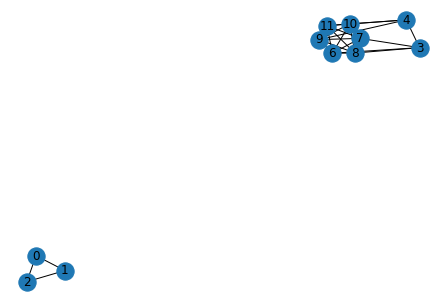

In [11]:
graph_QUBO = qubo_to_nx_graph(qubo_dictionary)
nx.draw(graph_QUBO, with_labels=True)

# Run

## Get Embedding with ```  minorminer  ``` as part of EmbeddingComposite() and safe it

https://docs.dwavesys.com/docs/latest/handbook_embedding.html#example-clique-embedding-a-sparse-bqm

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=sampleset_1#read-anneal-cycles

In [12]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
qpu = DWaveSampler(solver={'topology__type': 'pegasus'})

In [13]:
# Each run with 500 shots (more runs with less shots yield better results than less runs with more shots)
numr = 500

# Chain Strength = Max(QUBO) // Analog zur D Wave Dokumentation

chnstr = uniform_torque_compensation

# Empty array
data=[]

### And Visualize embedding,  check for Chain Breaks and run inspection with ```dwave.inspector.```

#### First Embedding

In [14]:
solver_graph = qpu.to_networkx_graph()

In [15]:
embedding = minorminer.find_embedding(qubo_dictionary, solver_graph)


In [17]:
sampleset1A = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [18]:
analyze(sampleset1A, "embedding1A", data)

Good solutions are 71.4% of samples.
Best Known solutions are 27.6% of samples.
Lowest energy found: [-8.0]
Average energy is -7.26 with standard deviation 1.13


In [19]:
sampleset1B = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [20]:
analyze(sampleset1B, "embedding1B", data)

Good solutions are 70.6% of samples.
Best Known solutions are 17.6% of samples.
Lowest energy found: [-8.0]
Average energy is -7.19 with standard deviation 1.25


In [21]:
print(sampleset1A.info["embedding_context"]["chain_strength"])    

5.081882689187804


In [23]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.0 and >0 is 0.0.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset1A)

#### Second Embedding

In [24]:
solver_graph = qpu.to_networkx_graph()

In [25]:
embedding2 = minorminer.find_embedding(qubo_dictionary, solver_graph)


In [26]:
sampleset2A = FixedEmbeddingComposite(qpu, embedding2).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [27]:
analyze(sampleset2A, "embedding2A", data)

Good solutions are 72.6% of samples.
Best Known solutions are 28.2% of samples.
Lowest energy found: [-8.0]
Average energy is -7.30 with standard deviation 1.08


In [28]:
sampleset2B = FixedEmbeddingComposite(qpu, embedding2).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [29]:
analyze(sampleset2B, "embedding2B", data)

Good solutions are 73.8% of samples.
Best Known solutions are 35.8% of samples.
Lowest energy found: [-8.0]
Average energy is -7.33 with standard deviation 1.06


In [30]:

print(sampleset2A.info["embedding_context"]["chain_strength"])    

5.081882689187804


In [32]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.0 and >0 is 0.0.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset2A) 

## Run for different Times and Schedules

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=anneal_schedule#annealing-schedule

https://docs.dwavesys.com/docs/latest/c_qpu_0.html?highlight=quench

In [ ]:
#qpu.properties["default_annealing_time"]      
# 20

### Find Sweet Spot for Annealing Time

In [33]:
#10
sampleset_10 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=10)  


In [34]:
analyze(sampleset_10, "time_10", data)

Good solutions are 66.0% of samples.
Best Known solutions are 30.0% of samples.
Lowest energy found: [-8.0]
Average energy is -7.09 with standard deviation 1.35


In [35]:
#15
sampleset_15 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=15)


In [36]:
analyze(sampleset_15, "time_15", data)

Good solutions are 75.8% of samples.
Best Known solutions are 34.4% of samples.
Lowest energy found: [-8.0]
Average energy is -7.36 with standard deviation 1.08


In [37]:
#20
sampleset_20 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=20)

In [38]:
analyze(sampleset_20, "time_20", data)

Good solutions are 68.0% of samples.
Best Known solutions are 30.6% of samples.
Lowest energy found: [-8.0]
Average energy is -7.16 with standard deviation 1.26


In [39]:
#25
sampleset_25 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=25)

In [40]:
analyze(sampleset_25, "time_25", data)

Good solutions are 76.8% of samples.
Best Known solutions are 37.8% of samples.
Lowest energy found: [-8.0]
Average energy is -7.40 with standard deviation 1.04


In [41]:
#30
sampleset_30 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=30)

In [42]:
analyze(sampleset_30, "time_30", data)

Good solutions are 72.2% of samples.
Best Known solutions are 35.2% of samples.
Lowest energy found: [-8.0]
Average energy is -7.26 with standard deviation 1.21


### Find best Schedule

### Pause and Quench

<img src="https://docs.dwavesys.com/docs/latest/_images/16q-pause.png" alt="drawing" width="600"/>

First verify the quench schedule

##### Random Walk

In [45]:
anneal_time=[10.0, 20.0, 50.0]
quench_slopes=[1.0, 0.5, 0.25]

# start times
num_points=5
s_low=0.2
s_high=0.9
quench_start=np.linspace(s_low, s_high, num=num_points)

success_prob = pd.DataFrame(index=range(len(anneal_time)*len(quench_slopes)*len(quench_start)),
                                columns=["anneal_time", "quench_slope", "s_feature", "success_frac"],
                                data=None)
counter=0

for anneal in anneal_time:
    for quench in quench_slopes:
        for start in quench_start:
            schedule=[[0.0,0.0],[start*anneal,start],[(1-start+quench*start*anneal)/quench, 1.0]]
            results = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr,
                                                              label='Notebook - Anneal Schedule',
                                                              chain_strength= chnstr,
                                                              anneal_schedule=schedule,)
            
            success_prob.iloc[counter]={"anneal_time":anneal, 
                                        "quench_slope":quench, 
                                        "s_feature":start,
                                        "success_frac":np.count_nonzero(results.record.energy == -8.0)/numr}
            counter+=1

In [46]:
success_prob

,anneal_time,quench_slope,s_feature,success_frac
0,10,1,0.2,0.23
1,10,1,0.375,0.282
2,10,1,0.55,0.218
3,10,1,0.725,0.292
4,10,1,0.9,0.232
5,10,0.5,0.2,0.29
6,10,0.5,0.375,0.196
7,10,0.5,0.55,0.196
8,10,0.5,0.725,0.302
9,10,0.5,0.9,0.256


In [ ]:
### Best Results with Anneal Time 50, Slope 0.25, and s_feature 0.725 or Slope 0.5, and s_feature 0.55 (SUM = 1)

In [48]:
anneal_time=[10.0, 50.0, 100.0]
pause_duration=[10.0, 100.0, 500.0]

# Create list of start times
num_points=5
s_low=0.2
s_high=0.6
pause_start=np.linspace(s_low, s_high, num=num_points)

success_prob = pd.DataFrame(index=range(len(anneal_time)*len(pause_duration)*len(pause_start)),
                                columns=["anneal_time", "pause_duration", "s_feature", "success_frac"],
                                data=None)
counter=0

for anneal in anneal_time:
    for pause in pause_duration:
        for start in pause_start:
            schedule=[[0.0,0.0],[start*anneal,start],[start*anneal+pause, start],[anneal+pause, 1.0]]
            results = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr,
                                                              label='Notebook - Anneal Schedule',
                                                              chain_strength= chnstr,
                                                              anneal_schedule=schedule,)
            
            success_prob.iloc[counter]={"anneal_time":anneal, 
                                        "quench_slope":quench, 
                                        "s_feature":start,
                                        "success_frac":np.count_nonzero(results.record.energy == -8.0)/numr}
            counter+=1

In [49]:
success_prob

,anneal_time,pause_duration,s_feature,success_frac
0,10,NaN,0.2,0.268
1,10,NaN,0.3,0.228
2,10,NaN,0.4,0.256
3,10,NaN,0.5,0.244
4,10,NaN,0.6,0.176
5,10,NaN,0.2,0.218
6,10,NaN,0.3,0.274
7,10,NaN,0.4,0.162
8,10,NaN,0.5,0.328
9,10,NaN,0.6,0.262


In [50]:
success_prob.to_numpy()

array([[10.0, nan, 0.2, 0.268],
       [10.0, nan, 0.3, 0.228],
       [10.0, nan, 0.4, 0.256],
       [10.0, nan, 0.5, 0.244],
       [10.0, nan, 0.6, 0.176],
       [10.0, nan, 0.2, 0.218],
       [10.0, nan, 0.3, 0.274],
       [10.0, nan, 0.4, 0.162],
       [10.0, nan, 0.5, 0.328],
       [10.0, nan, 0.6, 0.262],
       [10.0, nan, 0.2, 0.328],
       [10.0, nan, 0.3, 0.238],
       [10.0, nan, 0.4, 0.228],
       [10.0, nan, 0.5, 0.248],
       [10.0, nan, 0.6, 0.262],
       [50.0, nan, 0.2, 0.236],
       [50.0, nan, 0.3, 0.252],
       [50.0, nan, 0.4, 0.218],
       [50.0, nan, 0.5, 0.296],
       [50.0, nan, 0.6, 0.234],
       [50.0, nan, 0.2, 0.276],
       [50.0, nan, 0.3, 0.314],
       [50.0, nan, 0.4, 0.246],
       [50.0, nan, 0.5, 0.324],
       [50.0, nan, 0.6, 0.32],
       [50.0, nan, 0.2, 0.264],
       [50.0, nan, 0.3, 0.25],
       [50.0, nan, 0.4, 0.282],
       [50.0, nan, 0.5, 0.268],
       [50.0, nan, 0.6, 0.304],
       [100.0, nan, 0.2, 0.26],
       [10

### Combination of both best results:

In [58]:
schedule=[[0.0,0.0],[25,0.5],[125,0.5],[126, 1.0]]





In [59]:
results = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr,
                                                              label='Notebook - Anneal Schedule',
                                                              chain_strength= chnstr,
                                                              anneal_schedule=schedule,)

In [60]:
analyze(results, "combination", data)

Good solutions are 69.2% of samples.
Best Known solutions are 26.6% of samples.
Lowest energy found: [-8.0]
Average energy is -7.13 with standard deviation 1.39


# Its Just bloody random :(

### Reverse

In brief, reverse annealing is a technique that makes it possible to refine known good local solutions, thereby increasing performance for certain applications.

There are three parameters you can use to configure reverse annealing using Ocean:

1. `anneal_schedule` defines the annealing schedule that should be followed.
2. `initial_state` specifies the classical state at which the reverse anneal should start.
3. `reinitialize_state` specifies whether or not the initial state should be used for every anneal in the request.  If False, then after the first, each subsequent anneal starts where the previous finished.

<img src="https://docs.dwavesys.com/docs/latest/_images/ra.png" alt="drawing" width="600"/>


A Reverse schedule always starts at `s = 1.0`, and ours reverses quickly to `s = 0.45`, pauses for `100 μs`, then quickly anneals forward. The schedule is formatted as a list of  **[time, s]** pairs. The next cell plots the schedule.

A lower value of `s_target` implies a larger transverse field, which leads to a broader search of the solution space.  A greater value of `hold_time` means that the reverse anneal is given more time to explore, which leads to a broader and deeper search of the solution space.

In [23]:
# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start and end at s = 1.0
max_slope = 1.0/qpu.properties["annealing_time_range"][0]
reverse_schedule = make_reverse_anneal_schedule(s_target=0.45, hold_time=100, ramp_up_slope=max_slope)
time_total = reverse_schedule[3][0]

print(reverse_schedule)
print("Total anneal-schedule time is {} us".format(time_total))

[[0.0, 1.0], [2.75, 0.45], [102.75, 0.45], [103.3, 1.0]]
Total anneal-schedule time is 103.3 us


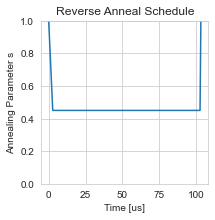

In [24]:
make_anneal_plot(reverse_schedule)

In [25]:
# Assign best Sampleset
best_sampleset = sampleset1B

In [26]:

i5 = int(5.0/95*len(best_sampleset))  # Index i5 is about a 5% indexial move from the sample of lowest energy

initial = dict(zip(best_sampleset.variables, best_sampleset.record[i5].sample))
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=True)

# The `reinitialize_state` parameter switches between two qualitatively different methods of local search 
# via quantum annealing.  With `reinitialize_state = 'True'`, many anneals are seeded from the single starting 
# state and the states returned, modulo time-dependent sources of error, are independently and identically 
# distributed.  With `reinitialize_state = 'False'`, the series of anneals behaves like a random walk and 
# is capable of exploring the solution space more broadly.  


In [65]:
sampleset_reverse1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [66]:
analyze(sampleset_reverse1, "reverse_schedule1", data)

Good solutions are 62.0% of samples.
Best Known solutions are 24.2% of samples.
Lowest energy found: [-8.0]
Average energy is -7.03 with standard deviation 1.26


In [27]:
get_hamming_distance = lambda x1, x2: np.sum(x1 != x2)

def get_hamming_distances(sols):
    sols = np.array(sols)
    return np.array([get_hamming_distance(x1, x2) for x1, x2 in zip(sols, sols[1:])])

In [28]:
import itertools
import seaborn 
seaborn.set_style('whitegrid')

s_target_vals = [0.3, 0.45, 0.6, 0.75, 0.9]
hold_time_vals =  [10, 50, 100, 150]

data_rows = list()
for s_target, hold_time in itertools.product(s_target_vals, hold_time_vals):
    
    print("Running reverse anneals with s_target={} and hold_time={} us".format(s_target, hold_time))
    schedule = make_reverse_anneal_schedule(s_target=s_target, hold_time=hold_time, ramp_up_slope=max_slope)
    reverse_anneal_params = dict(anneal_schedule=schedule, initial_state=initial, reinitialize_state=True)
    modulating_answer = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  
    modulating_solutions, modulating_energies = modulating_answer.record.sample, modulating_answer.record.energy
    modulating_distances = get_hamming_distances(modulating_solutions)
    row = dict(
        s_target=s_target,
        hold_time=hold_time,
        energy_stdev=np.std(modulating_energies),
        energy_mean=np.mean(modulating_energies),
        distance_mean=np.mean(modulating_distances),
        bks = np.count_nonzero(modulating_answer.record.energy == -8.0)/numr,
        gks = np.count_nonzero(modulating_answer.record.energy < -7.5)/numr
    )
    data_rows.append(row)

df = pd.DataFrame(data_rows)


Running reverse anneals with s_target=0.3 and hold_time=10 us
Running reverse anneals with s_target=0.3 and hold_time=50 us
Running reverse anneals with s_target=0.3 and hold_time=100 us
Running reverse anneals with s_target=0.3 and hold_time=150 us
Running reverse anneals with s_target=0.45 and hold_time=10 us
Running reverse anneals with s_target=0.45 and hold_time=50 us
Running reverse anneals with s_target=0.45 and hold_time=100 us
Running reverse anneals with s_target=0.45 and hold_time=150 us
Running reverse anneals with s_target=0.6 and hold_time=10 us
Running reverse anneals with s_target=0.6 and hold_time=50 us
Running reverse anneals with s_target=0.6 and hold_time=100 us
Running reverse anneals with s_target=0.6 and hold_time=150 us
Running reverse anneals with s_target=0.75 and hold_time=10 us
Running reverse anneals with s_target=0.75 and hold_time=50 us
Running reverse anneals with s_target=0.75 and hold_time=100 us
Running reverse anneals with s_target=0.75 and hold_time

In [29]:
df

,s_target,hold_time,energy_stdev,energy_mean,distance_mean,bks,gks
0,0.30,10,1.519995e+00,-6.94445,3.821643,0.236,0.626
1,0.30,50,1.482070e+00,-6.96883,3.935872,0.262,0.628
2,0.30,100,1.454066e+00,-6.90741,3.955912,0.164,0.604
3,0.30,150,1.658536e+00,-6.76317,3.991984,0.204,0.560
4,0.45,10,1.500188e+00,-6.94087,3.943888,0.202,0.616
5,0.45,50,1.331319e+00,-7.08676,3.727455,0.222,0.652
6,0.45,100,1.470142e+00,-6.97454,3.547094,0.236,0.624
7,0.45,150,1.529042e+00,-6.91834,3.811623,0.274,0.614
8,0.60,10,9.667767e-01,-7.33521,1.623246,0.002,0.736
9,0.60,50,1.140274e+00,-7.31900,1.667335,0.000,0.752


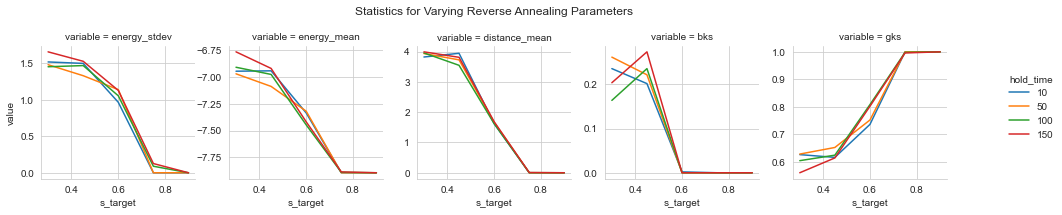

In [30]:
df_long = pd.melt(df, id_vars=['s_target', 'hold_time'])
g = seaborn.FacetGrid(df_long, hue='hold_time', col='variable', sharey=False, legend_out=True)
g.map(plt.plot, 's_target', 'value')
g.add_legend()
plt.suptitle("Statistics for Varying Reverse Annealing Parameters")
plt.subplots_adjust(left=.1, right=.9, top=.8)

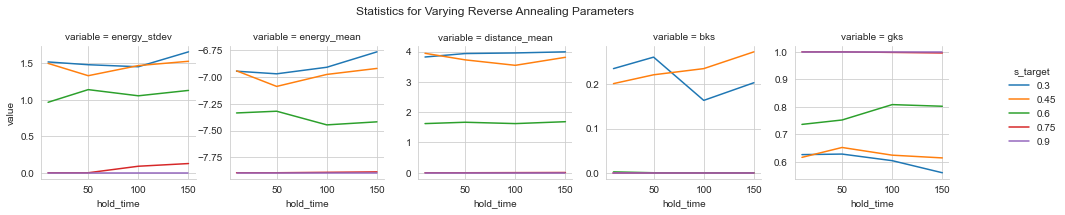

In [31]:
df_hold = pd.melt(df, id_vars=['s_target', 'hold_time'])
g = seaborn.FacetGrid(df_long, hue='s_target', col='variable', sharey=False, legend_out=True)
g.map(plt.plot, 'hold_time', 'value')
g.add_legend()
plt.suptitle("Statistics for Varying Reverse Annealing Parameters")
plt.subplots_adjust(left=.1, right=.9, top=.8)

#### Conclusion:

Reverse Annealing cannot increase the number of Best Known Solution as easily as hoped
BUT the Good Known Solutions can be maxed out by starting from an already known good solution
Therefore, if the Slope is too steep, only local minima (= same solutions as already found) will be found. The global Optimum will not be reached

```s-target``` should be around 0.45 for finding a new global Optimum from an already known good solution

```holdtime``` seems to be less influential for the results overall -- but for the Best Known Solutions and ```s-target``` = 0.45, the results increase with hold time 

In [32]:
# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start and end at s = 1.0
max_slope = 1.0/qpu.properties["annealing_time_range"][0]
reverse_schedule = make_reverse_anneal_schedule(s_target=0.45, hold_time=200, ramp_up_slope=max_slope)
time_total = reverse_schedule[3][0]

print(reverse_schedule)
print("Total anneal-schedule time is {} us".format(time_total))

[[0.0, 1.0], [2.75, 0.45], [202.75, 0.45], [203.3, 1.0]]
Total anneal-schedule time is 203.3 us


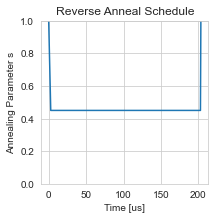

In [33]:
make_anneal_plot(reverse_schedule)

In [34]:

i5 = int(5.0/95*len(best_sampleset))  # Index i5 is about a 5% indexial move from the sample of lowest energy

initial = dict(zip(best_sampleset.variables, best_sampleset.record[i5].sample))
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=True)

# The `reinitialize_state` parameter switches between two qualitatively different methods of local search 
# via quantum annealing.  With `reinitialize_state = 'True'`, many anneals are seeded from the single starting 
# state and the states returned, modulo time-dependent sources of error, are independently and identically 
# distributed.  With `reinitialize_state = 'False'`, the series of anneals behaves like a random walk and 
# is capable of exploring the solution space more broadly.  


In [35]:
sampleset_reverse1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [36]:
analyze(sampleset_reverse1, "reverse_schedule1", data)

Good solutions are 64.4% of samples.
Best Known solutions are 27.8% of samples.
Lowest energy found: [-8.0]
Average energy is -7.01 with standard deviation 1.57


### But even for the best parameters, the results are on par with forward annealing